In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import glob

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download muhammadhananasghar/human-emotions-datasethes -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 98% 304M/309M [00:02<00:00, 175MB/s]
100% 309M/309M [00:02<00:00, 139MB/s]


In [83]:
train_dir = "/content/EmotionsDataset_Splitted/data/train/"
test_dir = "/content/EmotionsDataset_Splitted/data/test/"

CLASS_NAMES = ['angry','happy','nothing','sad']

In [84]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,  # Only include this once
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)


Found 3152 files belonging to 4 classes.


In [85]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,  # Only include this once
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)


Found 788 files belonging to 4 classes.


In [86]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 85.      ,  61.      ,  51.      ],
         [ 79.3125  ,  55.3125  ,  45.3125  ],
         [ 80.0625  ,  55.375   ,  47.4375  ],
         ...,
         [190.      , 184.      , 184.      ],
         [190.5625  , 184.5625  , 184.5625  ],
         [193.      , 187.      , 187.      ]],

        [[ 70.375   ,  43.9375  ,  34.75    ],
         [ 60.726562,  34.289062,  25.101562],
         [ 55.535156,  28.96875 ,  20.167969],
         ...,
         [186.39453 , 180.39453 , 180.39453 ],
         [190.05469 , 184.05469 , 184.05469 ],
         [193.8125  , 187.8125  , 187.8125  ]],

        [[ 85.5625  ,  56.5     ,  46.8125  ],
         [ 81.14453 ,  52.08203 ,  42.39453 ],
         [ 79.78125 ,  51.664062,  41.503906],
         ...,
         [187.92578 , 181.92578 , 181.92578 ],
         [189.16406 , 183.16406 , 183.16406 ],
         [189.875   , 183.875   , 183.875   ]],

        ...,

        [[215.0625  , 169.0625  

# Dataset Visualization

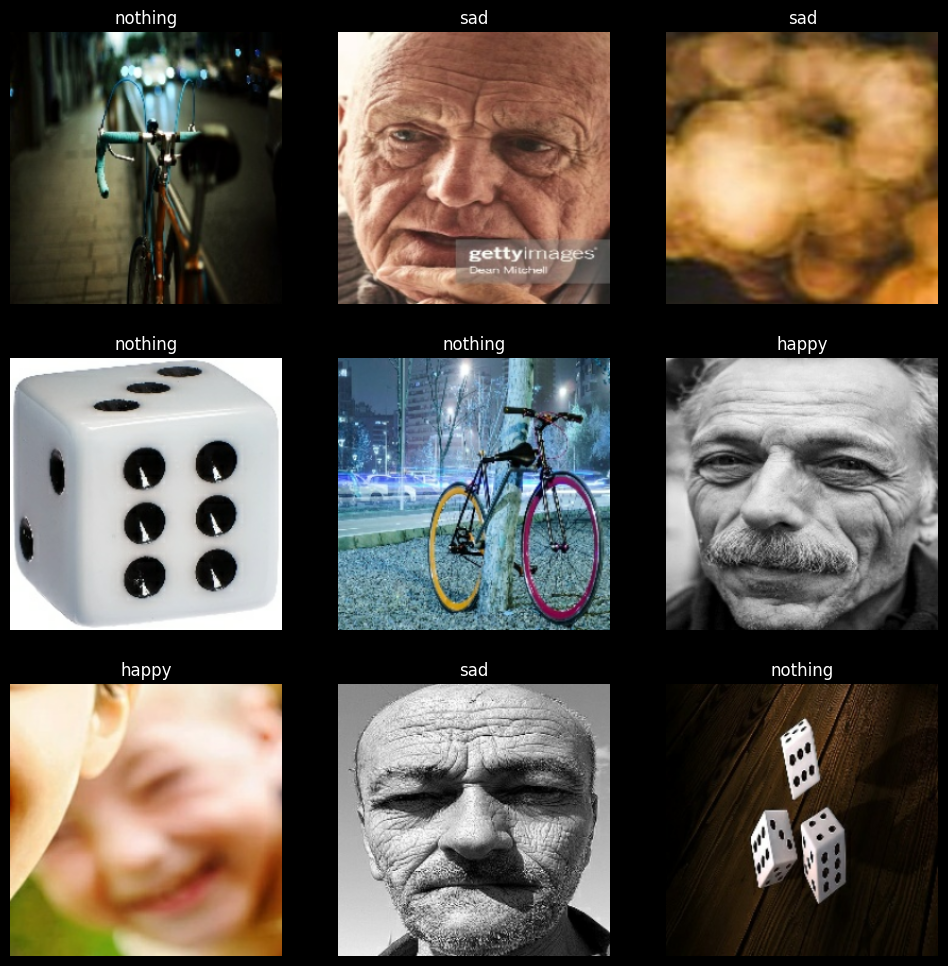

In [87]:
plt.figure(figsize =(12,12))

for images, label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[label[i]])
    plt.axis("off")

# Dataset Preperation

In [88]:
# Prefetch datasets for better performance
training_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [91]:
# Define the data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    tf.keras.layers.RandomRotation(0.2),                   # Randomly rotate images
    tf.keras.layers.RandomZoom(0.1),                       # Randomly zoom images
    tf.keras.layers.RandomTranslation(0.1, 0.1),           # Randomly translate images
    tf.keras.layers.RandomContrast(0.2),                   # Adjust image contrast
    tf.keras.layers.RandomBrightness(0.2),                 # Adjust image brightness
], name="data_augmentation")


# Resize and rescale layers
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0 / 255),
])

# Combine augmentation and preprocessing layers into a pipeline
augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),  # Explicit input shape
    data_augmentation,
    resize_rescale_layers,
], name="augmentation_pipeline")

# Apply transformations to train and validation datasets
train_dataset = training_dataset.map(lambda x, y: (augmentation_pipeline(x), y))
val_dataset = validation_dataset.map(lambda x, y: (resize_rescale_layers(x), y))  # No augmentation on validation

# Prefetch datasets for better performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# Modeling

In [92]:
CONFIUGRATION = {
    'BATCH_SIZE':32,
    'IM_SIZE': 256,
    'LEARNING_RATE':0.001,
    'N_EPOCHS': 25,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1':100,
    'N_DENSE_2': 10,
    'NUM_CLASSES' : 4
}

In [93]:
from tensorflow.keras.layers import InputLayer, Rescaling, Conv2D, Flatten, Dense


lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(256, 256, 3)),
    Rescaling(1.0 / 255, name = "rescaling"),

    Conv2D(filters=CONFIUGRATION['N_FILTERS'], kernel_size=CONFIUGRATION['KERNEL_SIZE'],
           strides = CONFIUGRATION['N_STRIDES'],activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(CONFIUGRATION['REGULARIZATION_RATE'])),

    BatchNormalization(),
    MaxPooling2D(pool_size= CONFIUGRATION['POOL_SIZE'],
                 strides = CONFIUGRATION['N_STRIDES']*2 ),

    Dropout(rate = CONFIUGRATION['DROPOUT_RATE']),

    Conv2D(filters=CONFIUGRATION['N_FILTERS'] * 2 + 4, kernel_size=CONFIUGRATION['KERNEL_SIZE'],
           strides = CONFIUGRATION['N_STRIDES'],activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(CONFIUGRATION['REGULARIZATION_RATE'])),

    BatchNormalization(),
    MaxPooling2D(pool_size= CONFIUGRATION['POOL_SIZE'],
                 strides = CONFIUGRATION['N_STRIDES']*2 ),

    Flatten(),

    Dense(units = CONFIUGRATION['N_DENSE_1'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(CONFIUGRATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = CONFIUGRATION['DROPOUT_RATE']),

    Dense(units = CONFIUGRATION['N_DENSE_2'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(CONFIUGRATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(CONFIUGRATION['NUM_CLASSES'], activation='sigmoid')
])

lenet_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │              44 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,130 (23.47 MB)

 Trainable params: 6,152,866 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [94]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

loss_function = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=CONFIUGRATION['LEARNING_RATE'])


In [95]:
lenet_model.compile(
    optimizer = optimizer,
    loss = loss_function,
    metrics = ['accuracy']
)

In [96]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)

In [97]:
# Fit the model
history = lenet_model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=val_dataset,  # Replace with your validation dataset
    epochs=50,
    batch_size=32,
    # steps_per_epoch=len(train_data) // 32,
    # validation_steps=len(valid_data) // 32,
    # callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 90s 849ms/step - accuracy: 0.4788 - loss: 1.1423 - val_accuracy: 0.2703 - val_loss: 1.4758
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 809ms/step - accuracy: 0.5472 - loss: 0.9457 - val_accuracy: 0.2703 - val_loss: 1.5506
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 78s 787ms/step - accuracy: 0.5798 - loss: 0.8966 - val_accuracy: 0.2703 - val_loss: 1.6399
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 800ms/step - accuracy: 0.5886 - loss: 0.8767 - val_accuracy: 0.2716 - val_loss: 1.5754
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 83s 816ms/step - accuracy: 0.5824 - loss: 0.8741 - val_accuracy: 0.3058 - val_loss: 1.3465
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 816ms/step - accuracy: 0.6115 - loss: 0.8556 - val_accuracy: 0.4657 - val_loss: 1.1172
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 78s 789ms/step - accuracy: 0.6049 - loss: 0.8419 - val_accuracy: 0.6421 - val_loss: 0.7949
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 79s 799ms/step - accuracy: 0.6015 - loss: 0.8324 - val_accu

In [98]:
lenet_model.save("lenet_model.keras")


# Testing and Evaluation


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


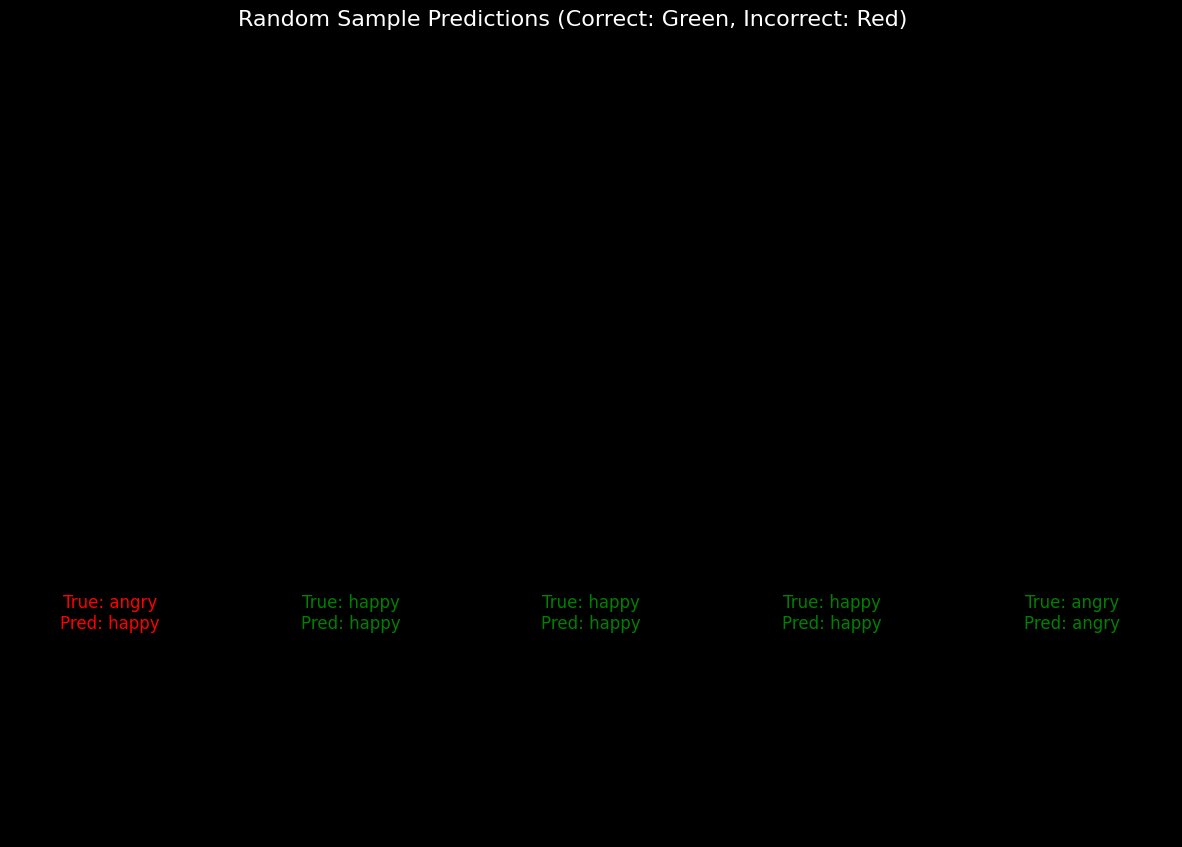

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the validation dataset
X_test_all = []
Y_true_all = []

for X_batch, Y_batch in val_dataset:  # Iterate through the dataset
    X_test_all.append(X_batch.numpy())  # Convert tensors to NumPy arrays
    Y_true_all.append(Y_batch.numpy())  # Convert tensors to NumPy arrays

# Concatenate all batches into single arrays
X_test_all = np.concatenate(X_test_all, axis=0)
Y_true_all = np.concatenate(Y_true_all, axis=0)

# Predict on the entire test dataset
Y_pred = lenet_model.predict(X_test_all)  # Predictions for the test set
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices

# Define class labels (if not already defined)
class_labels = CLASS_NAMES  # Replace with your class names

# Function to randomly sample images and check predictions
def plot_random_samples(X_data, Y_true, Y_pred_classes, class_labels, n=10):
    random_indices = np.random.choice(len(X_data), size=n, replace=False)  # Randomly select `n` indices
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_data[idx].astype("uint8"))  # Assuming images are RGB and in uint8 format
        true_label = class_labels[Y_true[idx]]  # Map integer to class name
        pred_label = class_labels[Y_pred_classes[idx]]  # Map integer to class name
        color = "green" if Y_true[idx] == Y_pred_classes[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Random Sample Predictions (Correct: Green, Incorrect: Red)", fontsize=16)
    plt.show()

# Choose `n` random samples and visualize
n = 5  # Number of random samples to display
plot_random_samples(X_test_all, Y_true_all, Y_pred_classes, class_labels, n=n)


In [100]:
Y_pred = lenet_model.predict(val_dataset)
score = lenet_model.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6760 - loss: 0.6997
Test loss: 0.7103988528251648
Test accuracy: 0.6789340376853943


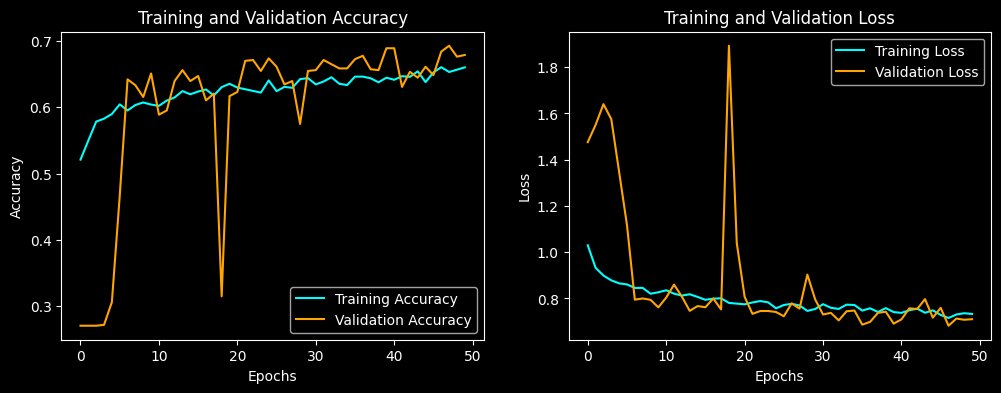

In [101]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = CLASS_NAMES# Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.31      0.36      0.33       213
       happy       0.27      0.29      0.28       207
     nothing       0.25      0.25      0.25       219
         sad       0.22      0.13      0.16       149

    accuracy                           0.27       788
   macro avg       0.26      0.26      0.25       788
weighted avg       0.26      0.27      0.26       788

Precision: 0.26, Recall: 0.27, F1 Score: 0.26


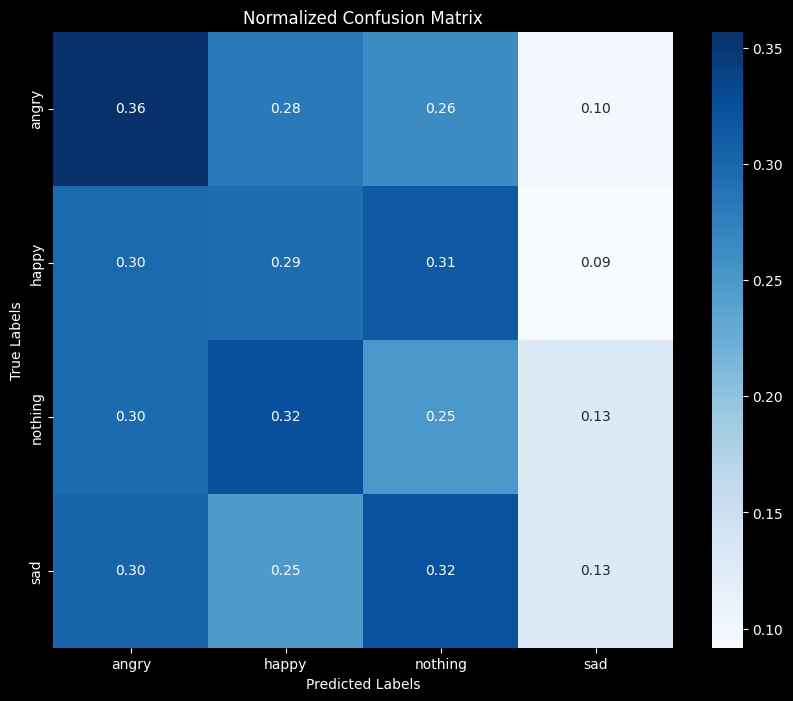

In [102]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels (Y_true) from val_dataset
Y_true = []
for _, labels in val_dataset:
    Y_true.extend(labels.numpy())  # Collect labels as a list
Y_true = np.array(Y_true)  # Convert to a NumPy array

# Predict on validation data
Y_pred = lenet_model.predict(val_dataset)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Generate a classification report
CLASS_NAMES = list(CLASS_NAMES)  # Ensure class names are available
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=CLASS_NAMES))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()
